# 24784 - Trustworthy AI Autonomy (Homework 2)

## Instructions
In this homework you are going to experiment with two model-based reinforcement learning (MBRL) algorithms. You will first code the missing part in models using [PyTorch](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and [GPyTorch](https://docs.gpytorch.ai/en/stable/).
You will then implement your algorithms to control a vehicle in an parking in [highway-env](https://github.com/eleurent/highway-env). This homework is modefied based on the colab [template](https://colab.research.google.com/github/eleurent/highway-env/blob/master/scripts/parking_model_based.ipynb#scrollTo=NwCDLD1wfvi2) from Edouard Leurent.

The main experiments uses **parking-v0** environment. The goal is to park a vehicle to a given goal location with the appropriate heading by controlling the gas pedal and steering angle.


# update 02/11

Hi class, we updated the template a bit to adapt to gym 0.26.2. 

## 0. Install and import packages



In [1]:
# Install environment
!pip install git+https://github.com/eleurent/highway-env#egg=highway-env
!pip install gym pyvirtualdisplay
!apt-get update

# Install visualization and Gaussian processes dependencies 
!apt-get install -y xvfb python-opengl ffmpeg -y
!pip install gpytorch
!pip install moviepy
!pip install imageio_ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/eleurent/highway-env to /tmp/pip-install-6aa5xc7a/highway-env_b0af0d566de14aa7bcb529d9ac0f7673
  Running command git clone --filter=blob:none --quiet https://github.com/eleurent/highway-env /tmp/pip-install-6aa5xc7a/highway-env_b0af0d566de14aa7bcb529d9ac0f7673
  Resolved https://github.com/eleurent/highway-env to commit abcef8da79dedf0dfdbe2db5b176d6f203366489
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/c

In [2]:
# Import environment
import gymnasium as gym
import highway_env

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
import gpytorch
from gpytorch.constraints import GreaterThan, Positive, LessThan

#suppress trivial warning from gpytorch
import warnings
warnings.filterwarnings("ignore", message="CG terminated in 1000 iterations")

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordVideo
import base64

# IO
from pathlib import Path

Here is a simple helper function for visualization of episodes directly in this Colab notebook:



In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_videos(path="videos"):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Here we set up the parking environment

In [4]:
env = gym.make("parking-v0", render_mode='rgb_array') #instantiate the parking environment 
VIDEO_PATH = './video' #designate the video path
env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda e: True, )
env.unwrapped.set_record_video_wrapper(env) #set up virtual monitor to store the video files at VIDEO_PATH dir

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


To see the configuration, run the following:

In [5]:
env.config

{'observation': {'type': 'KinematicsGoal',
  'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
  'scales': [100, 100, 5, 5, 1, 1],
  'normalize': False},
 'action': {'type': 'ContinuousAction'},
 'simulation_frequency': 15,
 'policy_frequency': 5,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 300,
 'centering_position': [0.5, 0.5],
 'scaling': 7,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'reward_weights': [1, 0.3, 0, 0, 0.02, 0.02],
 'success_goal_reward': 0.12,
 'collision_reward': -500,
 'steering_range': 0.7853981633974483,
 'duration': 100,
 'controlled_vehicles': 1,
 'vehicles_count': 0,
 'add_walls': True}

## 1.1. Running an episode with random actions

The environment is a `GoalEnv` type, which means the agent receives a dictionary containing both the current `observation` and the `desired_goal` that conditions its policy. In this case, `observation` or `achieved_goal` is the current states and `desired_goal` are the target.

/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:357: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


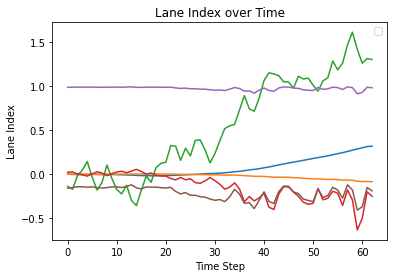

In [6]:
#run an episode
env.reset() #resetting the environment to start from a randomized state
done = False

rewards = []
states = []
i=0
while not done and i<=100:
  i+=1
  action = env.action_space.sample() #use random actions
  obs, reward, done, info = env.step(action)    # REPLACE THE THREE DOTS WITH YOUR OWN CODE

  #store the state and reward in a list
  rewards.append(reward) #store the reward in a list  
  states.append(obs)  
    # ... # REPLACE THE THREE DOTS WITH YOUR OWN CODE    
env.close()

#Which variable does store the achieved_goal or observation (s_n) and the desired_goal (s^*)?
# ... # REPLACE THE THREE DOTS WITH YOUR OWN CODE
plt.figure()
plt.plot([obs['observation'] for obs in states])
plt.title("Lane Index over Time")
plt.xlabel("Time Step")
plt.ylabel("Lane Index")
plt.legend()
plt.show()

## 1.2. Reward definition

The reward (or more specifically penalty, as it uses negative sign) here is the difference between the current state to the targe (parking space).

In [7]:
#Negative reward 
states_labels = env.config['observation']['features'] #the labels for the states
states_scales = env.config['observation']['scales'] #the scales for the states (if needed for plotting)

weights = np.array([1, 0.3, 0, 0, 0.02, 0.02]) #weights
weighted_norm=[]
p=0
for obs in states:
  p=sum(abs(obs['observation']-obs['desired_goal'])*weights)
  weighted_norm .append(-np.sqrt(p))# REPLACE THE THREE DOTS WITH YOUR OWN CODE

#plot the weighted norm over time
# REPLACE THE THREE DOTS WITH YOUR OWN CODE
weighted_norm[-1]

-0.7422496456361148

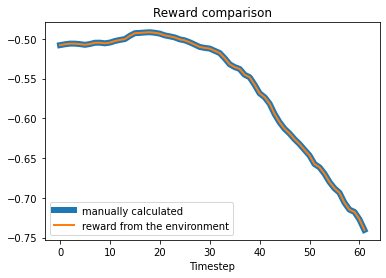

In [8]:
#not needed, but as hinted: 
#might be useful to compare the calculated weighted norm with the actual reward
#they should be the same if your calculation is correct

#Reward comparison
plt.plot(weighted_norm[:-1], lw=6, label="manually calculated")
plt.plot(rewards[:-1], lw=2, label="reward from the environment")
plt.title('Reward comparison')
plt.xlabel('Timestep')
plt.legend()
plt.show()

##1.3 Final reward and vehicle trajectory



Text(0.5, 1.0, 'Position of the car')

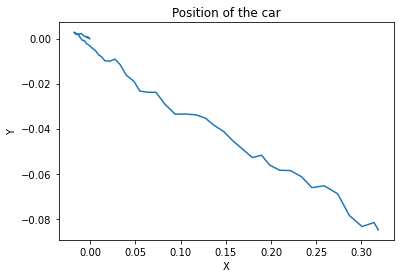

In [9]:
# final reward
final_reward=rewards[-1]# REPLACE THE THREE DOTS WITH YOUR OWN CODE

# Plot the trajectory of the vehicle (x and y position over timestep) 
x=[]
y=[]
for obs in states:
  x.append(obs['observation'][0])
  y.append(obs['observation'][1])

plt.plot(x,y) # REPLACE THE THREE DOTS WITH YOUR OWN CODE'
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Position of the car")

In [10]:
#load the video of the episode
show_videos('./videos')

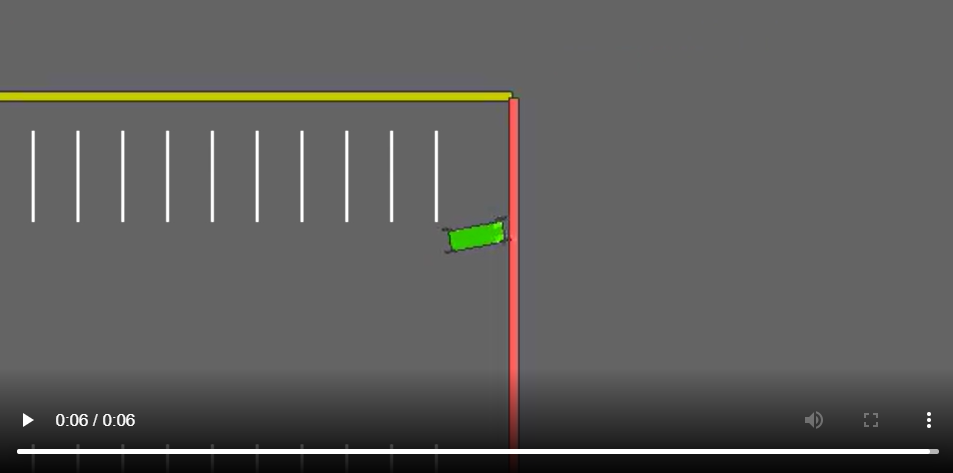

### 2.1 Build a dynamics model with NN


In [11]:
# reinitialize the env without recordvideo
env = gym.make("parking-v0", render_mode='rgb_array')

In [12]:
#NN structure
class NN_DynamicsModel(nn.Module):
    name = 'NN'
    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        self.layer1 = nn.Linear(state_size + action_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, state_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        :return x_{t+1}
        """
        xu = torch.cat((x, u), -1)
        xu = F.relu(self.layer1(xu))
        dx = self.layer2(xu).squeeze()
        
        # note that our prediction is delta x: dx = x_{t+1} - x_{t}, 
        # so how to obtain x_{t+1}?
        x_next = x+dx # REPLACE THE THREE DOTS WITH YOUR OWN CODE
        return x_next

Build NN dynamics model:

In [13]:
#parameters to instantiate the NN model
state_size = env.observation_space.spaces["observation"].shape[0] #observation dimension
action_size = env.action_space.shape[0] #action dimension
hidden_size = 128 #width of the hidden layer
timestep_duration = 1/env.unwrapped.config["policy_frequency"] #timestep duration of the environment

#instatiate the NN model
dynamics_nn = NN_DynamicsModel(state_size,action_size,hidden_size,timestep_duration)  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

In [14]:
#run a full episode with random actions and store the untrained nn predictions
state_data = []
pred_data = []
reward_data = []

#initialize the environment
env.reset()
done = False

while not done:
    action = env.action_space.sample()
    obs, reward, done, _, info = env.step(action)  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    state = obs['observation']  # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    # print(action)
    pred = dynamics_nn(torch.Tensor(state), torch.Tensor(action)).detach().numpy()

    #store the data
    state_data.append(state)
    pred_data.append(pred)
    reward_data.append(reward)

env.close()

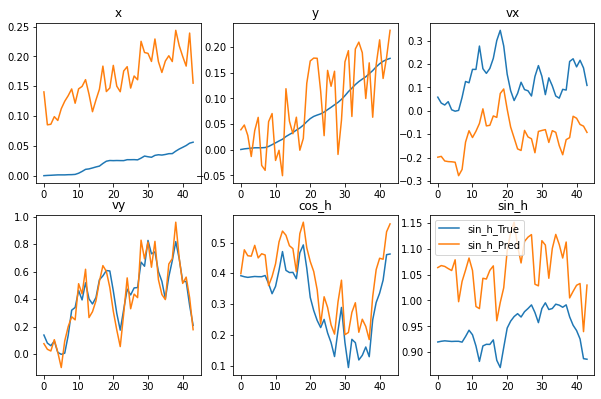

In [15]:
# Plot the true and predicted states
... # REPLACE THE THREE DOTS WITH YOUR OWN CODE
x_true=[x[0] for x in state_data]
x_pred=[x[0] for x in pred_data]
y_true=[x[1] for x in state_data]
y_pred=[x[1] for x in pred_data]
vx_true=[x[2] for x in state_data]
vx_pred=[x[2] for x in pred_data]
vy_true=[x[3] for x in state_data]
vy_pred=[x[3] for x in pred_data]
cos_h_true=[x[4] for x in state_data]
cos_h_pred=[x[4] for x in pred_data]
sin_h_true=[x[5] for x in state_data]
sin_h_pred=[x[5] for x in pred_data]
plt.figure(figsize=(10,10))
plt.subplot(331)
plt.plot(x_true,label='x_True')
plt.plot(x_pred,label='x_Pred')
plt.title('x')
plt.subplot(332)
plt.plot(y_true,label='y_True')
plt.plot(y_pred,label='y_Pred')
plt.title('y')
plt.subplot(333)
plt.plot(vx_true,label='vx_True')
plt.plot(vx_pred,label='vx_Pred')
plt.title('vx')
plt.subplot(334)
plt.plot(vy_true,label='vy_True')
plt.plot(vy_pred,label='vy_Pred')
plt.title('vy')
plt.subplot(335)
plt.plot(cos_h_true,label='cos_h_True')
plt.plot(cos_h_pred,label='cos_h_Pred')
plt.title('cos_h')
plt.subplot(336)
plt.plot(sin_h_true,label='sin_h_True')
plt.plot(sin_h_pred,label='sin_h_Pred')
plt.title('sin_h')
# plt.plot(pred_data[0:],label='Pred')
plt.legend()
# state_data

## 2.2 Model training

First, we randomly interact with the environment to produce a batch of experiences.
$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [16]:
#functions to create experiences dataset D

Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=2000, action_repeat=1):
    data, done = [], True
    for _ in trange(size):
        action = env.action_space.sample() #random sample actions
        for _ in range(action_repeat):
            previous_obs = env.reset()[0] if done else obs
            obs, reward, done, _, info = env.step(action)
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
    return data

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

In [17]:
size = 2000  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

data = collect_interaction_data(env, size=size)

print("Sample transition:", data[0])
print("Buffer size:", len(data))

  0%|          | 0/2000 [00:00<?, ?it/s]

Sample transition: Transition(state=tensor([ 0.0000,  0.0000,  0.0000, -0.0000,  0.8256, -0.5642]), action=tensor([-0.6776, -0.2868]), next_state=tensor([-3.4166e-04,  2.9551e-04, -1.1205e-01,  7.6228e-02,  8.2680e-01,
        -5.6249e-01]))
Buffer size: 2000


In [18]:
# Split dataset into training and validation

train_ratio = 0.7 # REPLACE THE THREE DOTS WITH YOUR OWN CODE

train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]

In [19]:
# functions to train the model

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def train(model, train_data, validation_data, epochs, learning_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)

    for epoch in trange(epochs):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["training", "validation"])
    plt.show()

Training the model

  0%|          | 0/1000 [00:00<?, ?it/s]

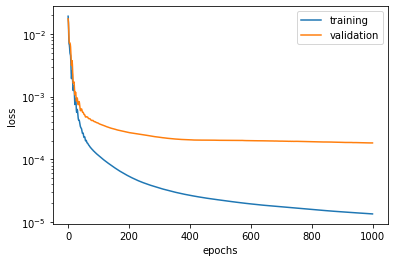

In [20]:
num_epochs = 1000 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
learning_rate = 0.01 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
train(dynamics_nn, train_data, validation_data, epochs=num_epochs, learning_rate = learning_rate)

## 2.3 Predictions of the trained NN

In [21]:
dynamics_nn.eval() #set the trained model for use

#run a full episode with random actions and store the trained nn predictions
state_data = []
pred_data = []
reward_data = []

#initialize the environment
env.reset()
done = False

while not done:
    action = env.action_space.sample()
    obs, reward, done, _, info = env.step(action)

    state = obs['observation']  # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    
    pred = dynamics_nn(torch.Tensor(state), torch.Tensor(action)).detach().numpy()

    #store the data
    state_data.append(state)
    pred_data.append(pred)
    reward_data.append(reward)

env.close()

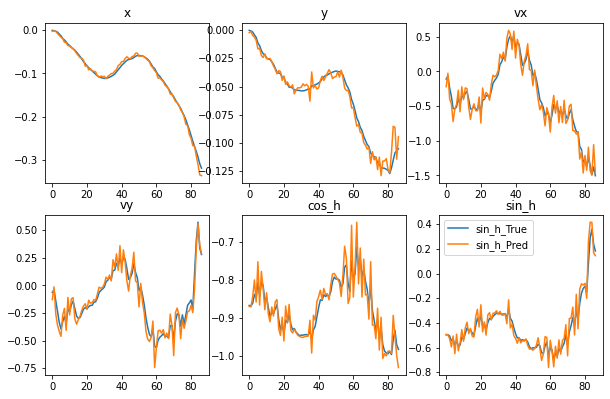

In [22]:
# Plot the true and predicted states
# Plot the true and predicted states
... # REPLACE THE THREE DOTS WITH YOUR OWN CODE
x_true=[x[0] for x in state_data]
x_pred=[x[0] for x in pred_data]
y_true=[x[1] for x in state_data]
y_pred=[x[1] for x in pred_data]
vx_true=[x[2] for x in state_data]
vx_pred=[x[2] for x in pred_data]
vy_true=[x[3] for x in state_data]
vy_pred=[x[3] for x in pred_data]
cos_h_true=[x[4] for x in state_data]
cos_h_pred=[x[4] for x in pred_data]
sin_h_true=[x[5] for x in state_data]
sin_h_pred=[x[5] for x in pred_data]
plt.figure(figsize=(10,10))
plt.subplot(331)
plt.plot(x_true,label='x_True')
plt.plot(x_pred,label='x_Pred')
plt.title('x')
plt.subplot(332)
plt.plot(y_true,label='y_True')
plt.plot(y_pred,label='y_Pred')
plt.title('y')
plt.subplot(333)
plt.plot(vx_true,label='vx_True')
plt.plot(vx_pred,label='vx_Pred')
plt.title('vx')
plt.subplot(334)
plt.plot(vy_true,label='vy_True')
plt.plot(vy_pred,label='vy_Pred')
plt.title('vy')
plt.subplot(335)
plt.plot(cos_h_true,label='cos_h_True')
plt.plot(cos_h_pred,label='cos_h_Pred')
plt.title('cos_h')
plt.subplot(336)
plt.plot(sin_h_true,label='sin_h_True')
plt.plot(sin_h_pred,label='sin_h_Pred')
plt.title('sin_h')
# plt.plot(pred_data[0:],label='Pred')
plt.legend()
# state_data

## CEM planner


In [23]:
#functions to help build the  CEM method
def predict_trajectory_actionlist(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            if model.name == 'GP':
                state = model(torch.cat((state, action), -1)).mean
            else: 
                state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the **Cross-Entropy Method** (`CEM`). It is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

In [24]:
def cem_planner(state, goal, action_size, model, horizon=5, population=10, selection=5, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, population, action_size)
    action_std = torch.ones(horizon, population, action_size)

    for iter_num in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = action_mean+ action_std.expand(horizon, population, action_size) * torch.randn(horizon, population, action_size)
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory_actionlist(state, actions, model, action_repeat=horizon)

        # 2. Fit the distribution to the top-k performing sequences
        returns = reward_model(states, goal).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]

        action_std = best_actions.std(dim=1, unbiased=False, keepdim=True)
        action_mean = best_actions.mean(dim=1, keepdim=True)  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    return action_mean[0].squeeze(dim=0)


Example of using the CEM to select actions:

In [25]:
# Run the planner on a sample transition

obs = env.reset()[0] #reset the environment to start

#run CEM to get actions using NN dynamics model
H = 3 #planning horizon
K = 10 #population size

action_nn = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0], dynamics_nn,
                     horizon=H, population=K)

print("Planned action:", action_nn)

Planned action: tensor([ 0.4795, -0.6063])


## 2.4. CEM with NN model

In [26]:
#run an episode for nn

#run an episode with random actions for at most n time steps
n = 20 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
H = 5 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
K = 10 # REPLACE THE THREE DOTS WITH YOUR OWN CODE

import time

nn_time = []
state_data_nn = []
reward_data_nn = []

env.reset()
done = False
i=0 #iterates
t=0
while (not done and i < n) :

    #use CEM with NN model to select actions
    start = time.time()
    state = obs["observation"]
    target = obs["desired_goal"]
    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    action = env.action_space.sample()
    obs, reward, done, _, info = env.step(action)
    obs_=obs['observation']

    end = time.time()
    #store the data
    t+=end-start
    nn_time.append(t)
    state_data_nn.append(obs_)
    reward_data_nn.append(reward)
    
    i+=1
    print(i, end="\n")
    
env.close()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Text(0.5, 1.0, 'Rewards vs Time')

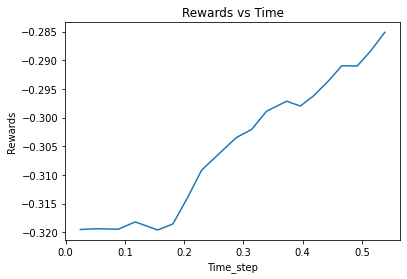

In [27]:
# Plot the rewards over time step
plt.plot(nn_time,reward_data_nn)
plt.xlabel('Time_step')
plt.ylabel('Rewards')
plt.title('Rewards vs Time')

### 3.1 Build a dynamics model with a Gaussian process

In [28]:
#GP model structure
#More details are available in gpytorch documentation: https://docs.gpytorch.ai/en/stable/

import gpytorch
from torch.utils.data import DataLoader

class MultitaskGPModel(gpytorch.models.ExactGP):
    name = 'GP'
    def __init__(self, train_x, train_y, likelihood, num_tasks=6): # number tasks is equivalent to the output dim
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.num_tasks = num_tasks
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        dists = gpytorch.distributions.MultitaskMultivariateNormal(mean_x + x[:,:self.num_tasks], covar_x)
        return dists

Build data pre-processing and prediction functions

In [29]:
#functions to prepare the data for GP training

def GP_dataloader_process(data, train_ratio = 0.3):
    # Split dataset into training and validation
    data_n = transpose_batch(data)
    inputs = torch.cat((data_n[0], data_n[1]), dim=1)
    targets = data_n[2]
    data_for_loader = []

    for i in range(inputs.shape[0]):
      data_for_loader.append([inputs[i], targets[i]])

    # prepare data for loader
    train_data_for_loader, validation_data_for_loader = data_for_loader[:int(train_ratio * len(data))], data_for_loader[int(train_ratio * len(data)):]

    # prepare data for GP 
    return train_data_for_loader, validation_data_for_loader

def GP_data_prepare(data, train_ratio = 0.3):
    # Split dataset into training and validation
    train_data, validation_data = data[:int(train_ratio * len(data))], \
                                  data[int(train_ratio * len(data)):]
    train_data_t = transpose_batch(train_data)
    states, actions, next_states = train_data_t
    train_x = torch.cat((states, actions), -1)
    train_y = next_states

    validation_data_t = transpose_batch(validation_data)
    val_states, val_actions, val_next_states = validation_data_t
    val_x = torch.cat((val_states, val_actions), -1)
    val_y = val_next_states
    return [train_x, train_y], [val_x, val_y]

def predict_trajectory(state, action, model, action_repeat=1):
    states = []
    for _ in range(action_repeat):
        if model.name == 'GP':
            state = model(torch.cat((state, action), -1)).mean
        else: 
            state = model(state, action)
        states.append(state)
    return torch.stack(states, dim=0)    

Training the GP model

In [30]:
train_ratio = 0.2

#prepare and split the dataset
train_data, validation_data = GP_data_prepare(data, train_ratio=train_ratio)
train_x, train_y = train_data
val_x, val_y = validation_data

# construct dynamics model
output_dim = 6 #the dimension of the state variables
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim, noise_constraint=GreaterThan(0.000001))

#instantiate the model
dynamics_gp = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=output_dim)

In [31]:
learning_rate = 0.2 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
epochs = 15 # REPLACE THE THREE DOTS WITH YOUR OWN CODE

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, dynamics_gp) #loss function
optimizer = torch.optim.Adam([{'params': dynamics_gp.parameters()},], lr=learning_rate) #adam optimizer

losses = np.full((epochs, 2), np.nan) #instantiate variables to store loss values

In [32]:
#iterate the training
for i in trange(epochs):
    dynamics_gp.train()
    likelihood.train()
    optimizer.zero_grad()

    output = dynamics_gp(train_x)
    loss = -mll(output, train_y) #compute the loss
    loss.backward() #backprop the error
    optimizer.step() #update the nn params

    dynamics_gp.eval()
    likelihood.eval()
    val_out = dynamics_gp(val_x)
    validation_loss = -mll(val_out, val_y) #compute the validation loss

    losses[i] = [loss.detach().numpy(), validation_loss.detach().numpy()] #store the computed loss

    print('Iter %d/%d - Loss: %.3f - Val Los: %.3f' % (i + 1, epochs, loss.item(), validation_loss.item()))

  0%|          | 0/15 [00:00<?, ?it/s]

Iter 1/15 - Loss: 1.151 - Val Los: 1.045
Iter 2/15 - Loss: 1.064 - Val Los: 0.959
Iter 3/15 - Loss: 0.976 - Val Los: 0.875
Iter 4/15 - Loss: 0.889 - Val Los: 0.790
Iter 5/15 - Loss: 0.803 - Val Los: 0.701
Iter 6/15 - Loss: 0.716 - Val Los: 0.613
Iter 7/15 - Loss: 0.626 - Val Los: 0.521
Iter 8/15 - Loss: 0.534 - Val Los: 0.427
Iter 9/15 - Loss: 0.441 - Val Los: 0.332
Iter 10/15 - Loss: 0.346 - Val Los: 0.235
Iter 11/15 - Loss: 0.249 - Val Los: 0.138
Iter 12/15 - Loss: 0.151 - Val Los: 0.040
Iter 13/15 - Loss: 0.052 - Val Los: -0.058
Iter 14/15 - Loss: -0.045 - Val Los: -0.158
Iter 15/15 - Loss: -0.144 - Val Los: -0.259


Text(0, 0.5, 'Loss')

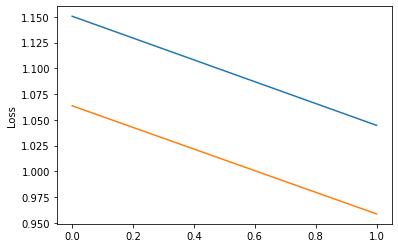

In [33]:
# Plot the training and validation losses

# Plot the true and predicted states
plt.plot(losses[0],label='Train')
plt.plot(losses[1],label='Validation')
plt.ylabel('Loss')

##3.2 Using the trained model for prediction

In [34]:
#run an episode with random actions for at most n time steps
n = 20

state_data_gp = []
pred_data_gp = []
reward_data_gp = []

env.reset()
done = False
i=0 #iterates

while (not done and i < n) :

    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    action = env.action_space.sample()
    obs, reward, done, _, info = env.step(action)
    state  = obs['observation'] 

    state = torch.Tensor(obs['observation']).unsqueeze(0) #convert the state to proper format
    action = torch.Tensor(action).unsqueeze(0)  #convert the action to proper format

    pred = predict_trajectory(state, action, dynamics_gp, action_repeat=1).detach().numpy() #GP prediction

    #store the data
    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    state_data_gp.append(state)
    pred_data_gp.append(pred)
    reward_data_gp.append(reward)

    i+=1
    print(i, end="\n")
env.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [35]:
x_true_gp=[]
x_pred_gp=[]
y_true_gp=[]
y_pred_gp=[]
vx_true_gp=[]
vx_pred_gp=[]
vy_true_gp=[]
vy_pred_gp=[]
cos_h_true_gp=[]
cos_h_pred_gp=[]
sin_h_true_gp=[]
sin_h_pred_gp=[]
for x in state_data_gp:
  x_true_gp.append(x[0][0])
  y_true_gp.append(x[0][1])
  vx_true_gp.append(x[0][2])
  vy_true_gp.append(x[0][3])
  cos_h_true_gp.append(x[0][4])
  sin_h_true_gp.append(x[0][5])
for x in pred_data_gp:
  x_pred_gp.append(x[0][0][0])
  y_pred_gp.append(x[0][0][1])
  vx_pred_gp.append(x[0][0][2])
  vy_pred_gp.append(x[0][0][3])
  cos_h_pred_gp.append(x[0][0][4])
  sin_h_pred_gp.append(x[0][0][5])

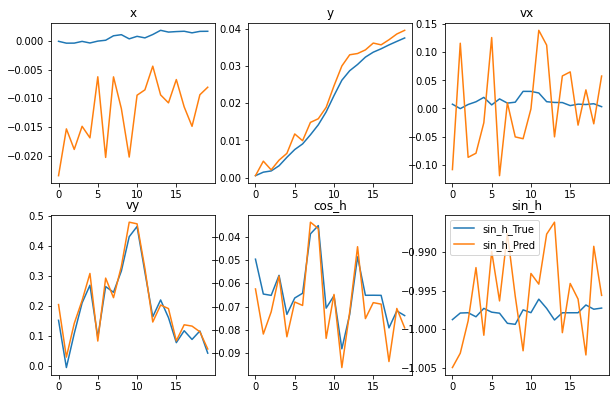

In [36]:
# Plot the true and predicted states

# Plot the true and predicted states
# Plot the true and predicted states
... # REPLACE THE THREE DOTS WITH YOUR OWN CODE
# x_true=[x[0][0][0] for x in state_data_gp]
# x_pred=[x[0][0][0] for x in pred_data_gp]
# y_true=[x[1][0][1] for x in state_data_gp]
# y_pred=[x[1][0][1] for x in pred_data_gp]
# vx_true=[x[2][0][2] for x in state_data_gp]
# vx_pred=[x[2][0][2] for x in pred_data_gp]
# vy_true=[x[3][0][3] for x in state_data_gp]
# vy_pred=[x[3][0][3] for x in pred_data_gp]
# cos_h_true=[x[4][0][4] for x in state_data_gp]
# cos_h_pred=[x[4][0][4] for x in pred_data_gp]
# sin_h_true=[x[5][0][5] for x in state_data_gp]
# sin_h_pred=[x[5][0][5] for x in pred_data_gp]
plt.figure(figsize=(10,10))
plt.subplot(331)
plt.plot(x_true_gp,label='x_True')
plt.plot(x_pred_gp,label='x_Pred')
plt.title('x')
plt.subplot(332)
plt.plot(y_true_gp,label='y_True')
plt.plot(y_pred_gp,label='y_Pred')
plt.title('y')
plt.subplot(333)
plt.plot(vx_true_gp,label='vx_True')
plt.plot(vx_pred_gp,label='vx_Pred')
plt.title('vx')
plt.subplot(334)
plt.plot(vy_true_gp,label='vy_True')
plt.plot(vy_pred_gp,label='vy_Pred')
plt.title('vy')
plt.subplot(335)
plt.plot(cos_h_true_gp,label='cos_h_True')
plt.plot(cos_h_pred_gp,label='cos_h_Pred')
plt.title('cos_h')
plt.subplot(336)
plt.plot(sin_h_true_gp,label='sin_h_True')
plt.plot(sin_h_pred_gp,label='sin_h_Pred')
plt.title('sin_h')
# plt.plot(pred_data[0:],label='Pred')
plt.legend()
# state_data

## 3.3. CEM with GP model

In [37]:
#run an episode for GP
import time
#run an episode with random actions for at most n time steps
n = 20 # REPLACE THE THREE DOTS WITH YOUR OWN CODE

state_data = []
reward_data = []
gp_time = []

env.reset()
done = False
i=0 #iterates

t=0
while not done and i < n:
    start = time.time()
    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    action = env.action_space.sample() #use CEM with GP model to select actions
    obs, reward, done, _, info = env.step(action)
    reward_data.append(reward)
    state = torch.Tensor(obs['observation']).unsqueeze(0) #convert the state to proper format
    action = torch.Tensor(action).unsqueeze(0)  #convert the action to proper format

    pred = predict_trajectory(state, action, dynamics_gp, action_repeat=1).detach().numpy() #GP prediction

    end = time.time()
    t+=t+end-start
    #store the data
    state_data.append(np.array(state).reshape(-1,))
    
    gp_time.append(t)

    i+=1
    print(i, end="\n")
    
env.close()
gp_reward = reward_data

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Text(0.5, 1.0, 'Reward v Time')

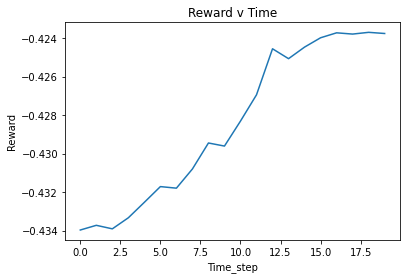

In [38]:
# Plot the rewards over time step
plt.plot(reward_data)
plt.xlabel('Time_step')
plt.ylabel('Reward')
plt.title('Reward v Time')

Text(0.5, 1.0, 'Reward v Time')

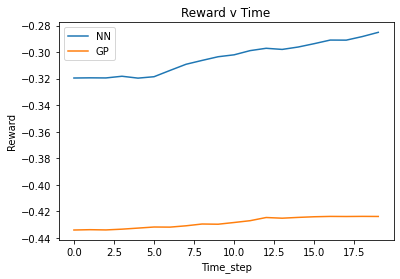

In [42]:
# Get the final reward (when using NN and GP with CEM)
plt.plot(reward_data_nn,label='NN')
plt.plot(reward_data,label='GP')
plt.legend()
plt.xlabel('Time_step')
plt.ylabel('Reward')
plt.title('Reward v Time')

Computing the prediction error, and computation time between NN and GP

In [40]:
# Compute the prediction error of NN and GP models during the planning horizon
print(f'Final reward with NN = {reward_data_nn[-1]}')
print(f'Final reward with GP = {reward_data_gp[-1]}')

print(f'Prediction error with NN = {np.abs(sum(reward_data_nn))}')
print(f'Prediction error with GP = {np.abs(sum(reward_data_gp))}')
... # REPLACE THE THREE DOTS WITH YOUR OWN CODE


# Get the computation time of running CEM with NN (from 2.4)and GP (from 3.3)
print(f'Computational time for the CEM with NN = {nn_time[-1]} seconds')
print(f'Computational time for the CEM with GP = {gp_time[-1]} seconds')

Final reward with NN = -0.2851069009607169
Final reward with GP = -0.36579230455364486
Prediction error with NN = 6.0884287949459726
Prediction error with GP = 7.432226747510873
Computational time for the CEM with NN = 0.5384657382965088 seconds
Computational time for the CEM with GP = 82566.7962744236 seconds


##Visualize a few episodes [Optional]

Here is a code to visualize a few episodes with CEM action planner.  This is optional, but might be helpful to gain insights. 

En voiture, Simone!

In [43]:
display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make("parking-v0", render_mode='rgb_array') #instantiate the parking environment 
VIDEO_PATH = './video-final' #designate the video path
env = RecordVideo(env, video_folder=VIDEO_PATH, episode_trigger=lambda e: True )
env.unwrapped.set_record_video_wrapper(env) #set up virtual monitor to store the video files at VIDEO_PATH dir
num_episodes = 5
H = 6
K = 25
iterations = 15

#select the dynamic model 
selected_dynamic_model = dynamics_nn #we will use NN model for its fast computation

for episode in trange(num_episodes):
    obs = env.reset()[0]
    done=False
    while (not done):
        action = cem_planner(torch.Tensor(obs["observation"]),
                             torch.Tensor(obs["desired_goal"]),
                             env.action_space.shape[0], selected_dynamic_model, 
                             horizon=H, population=K, iterations=iterations)
        obs, reward, done, info = env.step(action.numpy())
env.close()

In [44]:
show_videos(VIDEO_PATH)